<center> <img src="https://www.austral.edu.ar/ingenieria-posgrados/wp-content/uploads/2018/06/ua-ingenieria-color-logo.png"/> </center>

## Text Mining
## Proyecto: Clasificador de TED Talks





### 01.Preprocesamiento

#### 01.00 - Preparación del Entorno

In [252]:
# Instalación de Bibliotecas y recursos
! pip install -U spacy
! pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0.tar.gz
! pip install unidecode
! pip install bs4

# Importacion de bibliotecas
import os
import os.path
import pprint
import string
import unidecode
import ast
import re
import bs4
import time
import requests
import json
import random
import warnings
import gc
import pprint
import warnings
import nltk
import spacy
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Generales
from scipy.stats import gaussian_kde
from multiprocessing import Manager, Process
from bs4 import BeautifulSoup
from datetime import datetime
from google.colab import drive
from spacy import displacy

# NLTK
from nltk.text import Text
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures

# SKLEARN
from sklearn.cluster import AffinityPropagation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Variables
ted_file = 'Ted_Talk.csv'
language = 'english'

# PrettyPrinter
pp = pprint.PrettyPrinter(compact=True)
pp = pprint.PrettyPrinter(indent=4, compact=True)

# No mostrar warnings
warnings.filterwarnings('ignore')

nltk.download('all')
nltk.download('wordnet')

nlp = spacy.load("en_core_web_lg")

language_stops = set(stopwords.words(language))
language_stops.update(string.punctuation)

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)
     |████████████████████████████████| 778.7MB 20kB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-3.0.0-cp37-none-any.whl size=778750489 sha256=d0045c61f71131554f53dfa885562527529b477402979edb17bf17e0a63d324a
  Stored in directory: /root/.cache/pip/wheels/76/d4/24/e2bbc81bef966db10207f8280a6cdfd45d7a1d2f97657ab1a5
Successfully built en-core-web-lg
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |  

#### 01.01 - Funciones Principales

In [253]:
def remove_stop_words(text):
  """
    Remueve stop words en inglés

    Attributes
    ----------
    text: list
      lista de palabras (tokens) a filtrar

    Returns
    -------
    list
      lista de palabras sin los stop words
  """
  return [token for token in text if token.lower() not in language_stops]

In [254]:
def lematize_words(text):
  """
    Lematización de palabras - aplica lematización de palabras sobre un set de tokens

    Attributes
    ----------
    text: list
      lista de palabras (tokens) sobre los cuales se aplicará la lematización
    
    Returns
    -------
    list
      lista con todas las lematizaciones de las palabras
  """
  doc = nlp(" ".join(text))
  return [token.lemma_ for token in doc]

In [255]:
def remove_meaningless_words(text):
  """
    Remueve palabras sin significado

    Attributes
    ----------
    text: list
      lista de palabras (tokens) a filtrar
    
    Returns
    -------
    list
      lista de palabras filtrada en base a expresiones regulares
  """
  patterns = [r"(^={1,}=$)", r'\u200b']
  tokens = text
  for pattern in patterns:
    regexp = re.compile(pattern)
    tokens = [token for token in tokens if not regexp.search(token)]
  return tokens

In [257]:
def clean_short_words(text):
  """
    Limpia palabras con longitud 1

    Attributes
    ----------
    text: str
      documento a tokenizar
    
    Returns
    -------
    list
      lista de tokens
  """
  return [word for word in text if len(word) > 1]

In [259]:
def tokenize(text, mode='word'): 
  """
    Tokenización de documento - tokeniza un documento por palabra o por oración

    Attributes
    ----------
    text: str
      documento a tokenizar
    mode: str, optional
      método de tokenización (default: 'word' (por palabra))
    
    Returns
    -------
    list
      lista de tokens 
    
    Raises
    ------
      Exception
        si el mode no es 'word' o 'sentence'
  """
  if mode == 'word':
    return word_tokenize(text, language=language)
  elif mode == 'sentence':
    return sent_tokenize(text, language=language)
  else:
    raise Exception('metodo de tokenizacion no encontrado')

In [260]:
def similarity_btw_docs(matrix):
  """
    Similitud entre documentos - calcula la similitud entre documentos utilizando Similitud del Coseno

    Attributes
    ----------
    matrix: scipy matrix
      Matriz dispersa para calcular la similaridad

    Returns
    -------
    pd.DataFrame
      retorna un dataframe con el grado de similaridad entre documentos (de 0 a 1)
  """
  matrix_simil = cosine_similarity(matrix)
  return pd.DataFrame(matrix_simil)

In [261]:
def pre_procesamiento_texto(text):
  """
    Pre-procesamiento y obtención de las 20 palabras más significativas

    Attributes
    ----------
    text: str
      documento a analizar

    Returns
    -------
    pd.DataFrame
      retorna un dataframe con las 20 palabras que más se repiten y su frecuencia
  """
  tokenized = tokenize(text)
  without_stops = remove_stop_words(tokenized)
  meaningfull_tokens = remove_meaningless_words(without_stops)
  without_short_words = clean_short_words(meaningfull_tokens)
  lematized_words = lematize_words(without_short_words)
  return lematized_words

In [262]:
def remove_character(serie, char):
  """
    Pre-procesamiento y obtención de las 20 palabras más significativas

    Attributes
    ----------
    serie: pd.Serie
      columna de dataframe a modificar
    char: char
      caracter a remover

    Returns
    -------
    pd.Serie
      retorna una serie
  """
  return serie.str.replace(char, '')

In [263]:
def get_urls(page_list):
  """
    Obtencion de las urls de las charlas TED

    Attributes
    ----------
    page_list: list
      lista de paginas de charlas TED

    Returns
    -------
    list
      retorna una lista con todas las urls de las charlas TED
  """
  urls = ["https://www.ted.com" + url.select("div.media__image a.ga-link")[0].get("href") for url in page_list]
  return urls

In [264]:
def get_transcript(url, count):
  """
    Obtiene la transcripcion de una determinada charla ted

    Attributes
    ----------
    url: str
      url de la charla TED
    count: int
      indice de la pagina url

    Returns
    -------
    str
      retorna una cadena de caracteres con la transcripcion de la charla TED
  """
  transcript = ""
  transcript_res = requests.get(url, headers = {'User-agent': 'your bot 0.1'})
  soup = BeautifulSoup(transcript_res.text)
  e = soup.select('div.Grid.Grid--with-gutter.p-b:4')

  for  e_  in e:
    classes = e_.get('class')
    text = e_.select('p')[0].text
    transcript += text.strip().replace('\t', '').replace('\n', ' ')
                                
  if (transcript_res.status_code != 200) or (transcript_res.text == '') or (transcript == ''):
    count_=0
    while  count_ < 3: 
      time.sleep(random.randint(0,900)/1000)
      transcript_res = requests.get(url, headers = {'User-agent': 'your bot 0.1'})
      soup = BeautifulSoup(transcript_res.text)
      e = soup.select('div.Grid.Grid--with-gutter.p-b:4')

      for  e_  in e:
        classes = e_.get('class')
        text = e_.select('p')[0].text
        transcript += text.strip().replace('\t', '').replace('\n', ' ')

      count_ += 1
      if (transcript_res.status_code == 200) and (transcript_res.text != '') and (transcript != ''):
        break

  return transcript

In [265]:
def get__json_obj(url):
  """
    Obtiene el objecto JSON de una respectiva URL

    Attributes
    ----------
    url: str
      url a analizar

    Returns
    -------
    str
      retorna una cadena de caracteres que representa el objeto JSON de la URL
  """
  res = requests.get(url.strip(), headers = {'User-agent': 'your bot 0.1'})
  start_index = res.text.find('<script data-spec="q">q("talkPage.init",')
  end_index = res.text[start_index:].find(')</script>')
  script_tag = res.text[start_index: start_index + end_index]
  return script_tag[len('<script data-spec="q">q("talkPage.init",'):]

In [266]:
def get_value(l, m):
  """
    Obtiene el valor de un elemento HTML

    Attributes
    ----------
    l: list
      elementos
    m: s
      metadata

    Returns
    -------
    str
      retorna el valor del elemento HTML
  """
  for i in l:
    try:
      m = m[i]
    except: 
      return ''
  return m

In [267]:
def html_to_text(html):
  """
    Convierte un valor HTML a cadena de caracteres

    Attributes
    ----------
    html: str
      valor de elemento HTML

    Returns
    -------
    str
      retorna la representacion del valor del elemento HTML en cadena de caracdteres
  """
  if str(html) != 'nan':
    soup = BeautifulSoup(html)
    return soup.get_text()
  else: 
    return html

In [268]:
def get_elements_dict_from_url(count, url, json_obj):
  """
    Generacion de diccionario de elementos de una URL

    Attributes
    ----------
    count: int
      indice de la URL dentro del listado de URLs
    url: str
      url a analizar
    json_obj: str
      objeto JSON de la URL

    Returns
    -------
    dict
      retorna un diccionario que contiene todos los elementos HTML con sus respectivos valores
  """
  metadata = json.loads(json_obj)["__INITIAL_DATA__"]
  language = get_value(["language"], metadata)
  url__transcript = url + "/transcript?language=" + language
  temp = get_value(["talks", 0, "recorded_at"], metadata)
  t = get_value(["talks", 0, "player_talks", 0, "published"], metadata)

  elements_dict = dict()
  elements_dict["language"] = language
  elements_dict["talk__id"] = get_value(["current_talk"], metadata)
  elements_dict["talk__name"] = get_value(["talks", 0, "title"], metadata)
  elements_dict["talk__description"] = get_value(["description"], metadata)
  elements_dict["view_count"] = get_value(["viewed_count"], metadata)
  elements_dict["duration"] = get_value(["talks", 0, "duration"], metadata)
  elements_dict["transcript"] = get_transcript(url__transcript,count)
  elements_dict["video_type_name"] = get_value(["talks", 0, "video_type", "name"], metadata)
  elements_dict["event"] = get_value(["event"], metadata)               
  elements_dict["speaker__id"] = get_value(["speakers", 0, "id"], metadata)                        
  elements_dict["speaker__name"] = get_value(["talks", 0, "speaker_name"], metadata)
  elements_dict["speaker__description"] = get_value(["speakers", 0, "description"], metadata)
  elements_dict["speaker__who_he_is"] = get_value(["speakers", 0, "whotheyare"], metadata)
  elements_dict["speaker__why_listen"] = html_to_text(get_value(["speakers", 0, "whylisten"], metadata))
  elements_dict["all_speakers_details"] = get_value(["speakers"], metadata)                       
  elements_dict["recording_date"] = temp if temp == None else temp[:10]                        
  elements_dict["published_timestamp"] = datetime.utcfromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S')                      
  elements_dict["talks__tags"] = get_value(["talks", 0, "tags"], metadata)
  elements_dict["number_of__tags"] = len(get_value(["talks", 0, "tags"], metadata) or "")                       
  elements_dict["native_language"] = get_value(["talks", 0, "player_talks", 0, "nativeLanguage"], metadata)                   
  elements_dict["url__webpage"] = get_value(["url"], metadata)                    
  elements_dict["talk__more_resources"] = get_value(["talks", 0, "more_resources"], metadata)
  elements_dict["number_of__talk__more_resources"] = len(get_value(["talks", 0, "more_resources"], metadata) or "")
  elements_dict["talk__recommendations__blurb"] = get_value(["talks", 0, "recommendations", "blurb"], metadata)                    
  elements_dict["talk__recommendations"] = get_value(["talks", 0, "recommendations", "rec_lists"], metadata)
  elements_dict["number_of__talk__recommendations"] = len(get_value(["talks", 0, "recommendations", "rec_lists"], metadata) or "")
  elements_dict["related_talks"] = get_value(["talks", 0, "related_talks"], metadata)
  elements_dict["number_of__related_talks"] = len(get_value(["talks", 0, "related_talks"], metadata) or "")

  return elements_dict

In [269]:
def download(urls, id_, csv_list):
  """
    Descarga toda la informacion respecto a las charlas TED

    Attributes
    ----------
    urls: list
      lista de URLs a descargar
    id_: int
      id de cada pagina dentro de la lista
    csv_list: list
      csv donde se guardara la informacion respecto a las charlas ted
  """
  for count, url in enumerate(urls):
    json_obj = get__json_obj(url)

    if not json_obj:
      count=0
      while count < 3:    
        json_obj  =  get__json_obj(url)
        count += 1
        if json_obj:
          break

    if not json_obj:
      continue
    else:
      csv_list.append(get_elements_dict_from_url(count, url, json_obj))

In [270]:
def scrape_ted_urls(urls, file_name):
  """
    Realiza un proceso de web-scraping sobre todas las charlas TED

    Attributes
    ----------
    urls: list
      URL de charlas TED a scrappear
    file_name: list
      nombre de archivo donde se guardara toda la informacion de las charlas TED
  """
  csv_list_ = []
  
  with Manager() as manager:
      csv_list = manager.list()
      Processess = []
      
      urls_  = [urls[(i*(len(urls)//100)):((i+1)*(len(urls)//100))] for i in range(100)]
      
      leftovers = urls[(100*(len(urls)//100)):len(urls)]

      for i in range(len(leftovers)):
        urls_[i] += [leftovers[i]]
      
      for (id_,urls__) in enumerate(urls_):
          p = Process(target=download, args=(urls__,id_,csv_list))
          Processess.append(p)
          p.start()
          
      for t in Processess:
        t.join()
      
      csv_list_ = list(csv_list)

  dataframe_ted = pd.DataFrame(csv_list_).sort_values("view_count", ascending=False)
  dataframe_ted.to_csv(file_name, index=False, encoding='utf-8')

In [271]:
def get_page_text(page_number):
  """
    Obtiene la URL de una charla TED

    Attributes
    ----------
    page_number: int
      numero de pagina

    Returns
    -------
    str
      retorna la URL de una charla TED
  """
  res = requests.get("https://www.ted.com/talks?sort=popular&page=" + str(page_number), headers = {'User-agent': 'your bot 0.1'})
  soup = bs4.BeautifulSoup(res.text)
  element = soup.select("div.container.results div.col")
  return element

In [272]:
def retrieve_pages_url():
  """
    Obtiene las URL de todas las charlas TED en un determinado idioma

    Returns
    -------
    list
      retorna un listado de URL de cada charla TED en un determinado idioma
  """
  urls = []
  page_number=1

  while 1:
    page_list_urls = get_page_text(page_number)
    
    if len(page_list_urls) == 0:    
      break
    
    page_number += 1
    urls += get_urls(page_list_urls)

  file_ted = open('TED_Talk_URLs.txt', 'w')
  file_ted.write('\n'.join(urls))
  file_ted.close()

  return urls

#### 01.02 - Carga de Datos - Web Scrapping

In [273]:
# Activando Google Drive para guardar la información
drive.mount('/content/gdrive')

# Directorio donde se guardara/buscara el archivo que contiene la informacion de las charlas TED
os.chdir('/content/gdrive/My Drive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [274]:
# Si no existe el archivo de TED, hace toda la falopeada de web-scraping asquerosa copy-pasted (toma 6 minutos aprox)
if not os.path.isfile(ted_file):
  ted_urls = retrieve_pages_url()
  scrape_ted_urls(ted_urls, ted_file)

In [275]:
tedx_df = pd.read_csv(ted_file)
tedx_df.head()

,language,talk__id,talk__name,talk__description,view_count,duration,transcript,video_type_name,event,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,all_speakers_details,recording_date,published_timestamp,talks__tags,number_of__tags,native_language,url__webpage,talk__more_resources,number_of__talk__more_resources,talk__recommendations__blurb,talk__recommendations,number_of__talk__recommendations,related_talks,number_of__related_talks
0,en,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70720559,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,"['creativity', 'culture', 'dance', 'education'...",7,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,The education expert has a lot to say about th...,"[{'title': 'Reading list', 'description': '', ...",1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6
1,en,2405,This is what happens when you reply to spam email,"Suspicious emails: unclaimed insurance bonds, ...",63748917,588,"A few years ago, I got one of those spam email...",TED Stage Talk,TEDGlobal>Geneva,2664.0,James Veitch,"Comedian, writer","For James Veitch, spam emails proved the perfe...",James Veitch's correspondence with email spamm...,"[{'id': '2664', 'slug': 'james_veitch', 'is_pu...",2015-12-08,2020-10-23 13:51:31,"['comedy', 'curiosity', 'communication', 'humo...",5,en,https://www.ted.com/talks/james_veitch_this_is...,[],0,NaN,NaN,0,"[{'id': '2236', 'hero': 'https://pe.tedcdn.com...",4
2,en,1569,Your body language may shape who you are,(NOTE: Some of the findings presented in this ...,61647643,1262,So I want to start by offering you a free no-t...,TED Stage Talk,TEDGlobal 2012,1284.0,Amy Cuddy,Social psychologist,Amy Cuddy’s research on body language reveals ...,Amy Cuddy wasn’t supposed to become a successf...,"[{'id': '1284', 'slug': 'amy_cuddy', 'is_publi...",2012-06-26,2012-10-01 15:00:08,"['body language', 'brain', 'business', 'psycho...",7,en,https://www.ted.com/talks/amy_cuddy_your_body_...,"[{'status': 'approved', 'headline': 'Presence:...",4,NaN,NaN,0,"[{'id': '1042', 'hero': 'https://s3.amazonaws....",5
3,en,848,How great leaders inspire action,Simon Sinek has a simple but powerful model fo...,55070274,1084,How do you explain when things don't go as we ...,TEDx Talk,TEDxPuget Sound,703.0,Simon Sinek,Leadership expert,Simon Sinek explores how leaders can inspire c...,Fascinated by the leaders who make impact in t...,"[{'id': '703', 'slug': 'simon_sinek', 'is_publ...",2009-09-17,2010-05-04 09:31:00,"['TEDx', 'business', 'entrepreneur', 'leadersh...",5,en,https://www.ted.com/talks/simon_sinek_how_grea...,"[{'status': 'approved', 'headline': '*Start wi...",1,The leadership expert shares books and films t...,"[{'title': 'Reading List', 'description': '', ...",1,"[{'id': '1998', 'hero': 'https://pe.tedcdn.com...",6
4,en,1042,The power of vulnerability,Brené Brown studies human connection -- our ab...,53629104,1219,"So, I'll start with this: a couple years ago, ...",TEDx Talk,TEDxHouston,914.0,Brené Brown,"Vulnerability researcher, storyteller","Dr. Brené Brown studies courage, vulnerability...",Brené Brown is a research professor at the Uni...,"[{'id': '914', 'slug': 'brene_brown', 'is_publ...",2010-06-06,2010-12-23 14:45:00,"['TEDx', 'communication', 'culture', 'depressi...",10,en,https://www.ted.com/talks/brene_brown_the_powe...,"[{'status': 'approved', 'headline': '*Daring G...",2,Dive deeper into shame and vulnerability (in a...,"[{'title': 'Reading List', 'description': '', ...",1,"[{'id': '1391', 'hero': 'https://s3.amazonaws....",6


#### 01.03 - Exploración de los Datasets (DS)

##### *Dataset (DS):*
 Se genera un DS de trabajo con mas de 5000 observaciones a partir de la aplicación de Web Scrapping en https://www.ted.com/talks?sort=popular&page=1, el ds de trabajo contempla tanto la metadata de las ted talks como las transcripciones.

Variables:

1. talk__id: N° de ID de la Ted Talk
2. talk__name: Nombre de la Ted Talk
3. talk__description: Descripción de la Ted Talk
4. view_count: Cantidad de Vistas (visitas)
5. duration: duración de la Ted Talk en minutos
6. transcript: transcripción de la Ted Talk
7. video_type_name: Tipo de Ted Talk
8. event: evento
9. speaker__id: id del speaker
10. speaker__name: nombre del speaker
11. speaker__description: ocupación del speaker
12. speaker__who_he_is: descripción del Speaker
13. speaker__why_listen: 
14. all_speakers_details: 
15. recording_date: 
16. published_timestamp: 
17. talks__tags: Tags (Variable Target)
18. number_of__tags: cantidad de Tags
19. language: Idioma
20. native_language
21. url__webpage
22. talk__more_resources
23. number_of__talk__more_resources
24. talk__recommendations__blurb
25. talk__recommendations
26. number_of__talk__recommendations
27. related_talks
28. number_of__related_talks

In [276]:
#Dimensiones
print(f"Dimensiones de DS : {tedx_df.shape}")

Dimensiones de DS : (5127, 28)


In [277]:
#Valores Repetidos
tedx_df.loc[: , ["talk__id"]].size - np.unique(tedx_df.loc[: , ["talk__id"]]).size #Se confirma que hay un (1) valor duplicado

1

In [278]:
#Verificamos Observación Repetida
def repetidos(x):
  y = pd.Series(np.sort(x.values.tolist(), axis = None)).value_counts()
  return y[y > 1]

repetidos(tedx_df.loc[: , ["talk__id"]])

36409    2
dtype: int64

In [279]:
tedx_df[tedx_df.talk__id == 36409] #Considerando que la transcripción es de tipo NaN, se eliminará el duplicado en el siguiente paso.

,language,talk__id,talk__name,talk__description,view_count,duration,transcript,video_type_name,event,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,all_speakers_details,recording_date,published_timestamp,talks__tags,number_of__tags,native_language,url__webpage,talk__more_resources,number_of__talk__more_resources,talk__recommendations__blurb,talk__recommendations,number_of__talk__recommendations,related_talks,number_of__related_talks
3949,en,36409,An unexpected tool for understanding inequalit...,How do we make sense of a world that doesn't? ...,565745,679,"The world is awash with divisive arguments, co...",TEDx Talk,TEDxLondon,5215.0,Eugenia Cheng,"Mathematician, pianist","Eugenia Cheng devotes her life to mathematics,...",Dr. Eugenia Cheng quit her tenured academic jo...,"[{'id': '5215', 'slug': 'eugenia_cheng', 'is_p...",2018-07-01,2019-03-08 15:47:37,"['math', 'communication', 'visualizations', 'T...",7,en,https://www.ted.com/talks/eugenia_cheng_an_une...,"[{'status': 'approved', 'headline': '*The Art ...",1,NaN,NaN,0,"[{'id': '23865', 'hero': 'https://s3.amazonaws...",6
3950,en,36409,An unexpected tool for understanding inequalit...,How do we make sense of a world that doesn't? ...,565745,679,NaN,TEDx Talk,TEDxLondon,5215.0,Eugenia Cheng,"Mathematician, pianist","Eugenia Cheng devotes her life to mathematics,...",Dr. Eugenia Cheng quit her tenured academic jo...,"[{'id': '5215', 'slug': 'eugenia_cheng', 'is_p...",2018-07-01,2019-03-08 15:47:37,"['math', 'communication', 'visualizations', 'T...",7,en,https://www.ted.com/talks/eugenia_cheng_an_une...,"[{'status': 'approved', 'headline': '*The Art ...",1,NaN,NaN,0,"[{'id': '23865', 'hero': 'https://s3.amazonaws...",6


In [280]:
#Verificamos idioma:
def idiomas(x):
  y = pd.Series(np.sort(x.values.tolist(), axis = None)).value_counts()
  return y

idiomas(tedx_df.loc[: , ["language"]])

#Existen Ted Talks en distintos idiomas, seleccionamos solo las Ted Talks en Inglés

en    5107
es      19
fr       1
dtype: int64

In [281]:
tedx_df = tedx_df[tedx_df.language == 'en']

##### *Valores Ausentes / Missing Values:* 

Se observa para las siguientes variables una cantidad de NA's considerable (>= 0.5), por lo que se eliminarán del modelo.

Para la variable principal del modelo se observan 587 observaciones con datos faltantes, por ello se limpia el dataset.

In [282]:
#Todas las variables
tedx_df.isna().sum() / tedx_df.shape[0]

language                            0.000000
talk__id                            0.000000
talk__name                          0.000000
talk__description                   0.000000
view_count                          0.000000
duration                            0.000000
transcript                          0.116115
video_type_name                     0.000000
event                               0.000000
speaker__id                         0.002350
speaker__name                       0.000196
speaker__description                0.150186
speaker__who_he_is                  0.135109
speaker__why_listen                 0.229685
all_speakers_details                0.000000
recording_date                      0.000392
published_timestamp                 0.000000
talks__tags                         0.000000
number_of__tags                     0.000000
native_language                     0.000000
url__webpage                        0.000000
talk__more_resources                0.525553
number_of_

In [283]:
#Eliminamos NA's en transcription
tedx_df = tedx_df.dropna(subset = ['transcript'])
tedx_df.shape

(4514, 28)

In [284]:
y = tedx_df.isna().sum() / tedx_df.shape[0]
y[y >= 0.5].index

Index(['talk__recommendations__blurb', 'talk__recommendations'], dtype='object')

In [285]:
#Eliminamos Variables f > 0.5 NA's
tedx_df = tedx_df.drop(columns = y[y >= 0.5].index)

tedx_df.shape

(4514, 26)

#### 01.04 - Preprocesamiento de Dataset

Se toma como referencia el pipeline de: https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95 y se complementa con parte del pipeline de: https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79 (no se corre el tratamiento de contracciones ni de números en forma de texto al no poder instalar pip en Kaggle)

##### *Limpieza URL's:* 
Deberia ser irrelevante debido a que son transcripciones directas de charlas, no deberian existir referencias a URL's dentro del texto. No obstante, se ejecuta este paso de forma preventiva.

In [286]:
def clean_url(text):
    return re.sub(r'http\S+','',text)

tedx_df['CleanTranscript'] = tedx_df['transcript'].apply(clean_url)

##### *Limpieza de Tildes:* 
Deberia ser irrelevante debido a que son textos en Inglés, no obstante, se ejecuta este paso de forma preventiva.

In [287]:
def remove_tildes(text):
    return unidecode.unidecode(text)

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(remove_tildes)

##### *Limpieza de Caracteres Irrelevantes:* 

Se eliminan números y signos de puntuación. Hay que considerar el impacto sobre it's, i'm, entre otros...

In [288]:
def clean_non_alphanumeric(text):
   return re.sub('[^a-zA-Z]',' ',text)

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_non_alphanumeric)

##### *Estandarización de tamaño de letras:* 

Se convierten todos los caracteres a minusculas

In [289]:
def clean_lowercase(text):
    return str(text).lower()

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_lowercase)

#### 01.05 - Tags

Referencia: https://www.kaggle.com/rounakbanik/ted-data-analysis

##### *Segmentación por TAGS:* 

In [290]:
tedx_df = tedx_df[tedx_df['transcript'] != np.nan]
tedx_df = tedx_df[[len(ast.literal_eval(tag)) > 0 for tag in tedx_df['talks__tags']]]

##### *Segmentación por TAGS (cont):* 

Como resultado del web scrapping en la página TED, vemos que la variable `talks_tags` de cada charla puede tener múltiples valores (desde 0 tags hasta charlas que tienen 31).

La solución principal a nuestro modelo sería crear modelos que soporten variables target [*multioutput* y *multiclass*](https://scikit-learn.org/stable/modules/multiclass.html)

La exploración de la variable `talks_tags` en esta notebook pretende ver la viabilidad de simplificarlo en ese sentido.


In [291]:
# Importando base de datos y extrayendo variables de interés
datos = tedx_df[['talks__tags', 'number_of__tags']]

# Convirtiendo la variable 'talks__tags' en una lista
datos['talks__tags'] = datos['talks__tags'].apply(lambda x: ast.literal_eval(x))
datos.head(3)

,talks__tags,number_of__tags
0,"[creativity, culture, dance, education, parent...",7
1,"[comedy, curiosity, communication, humor, tech...",5
2,"[body language, brain, business, psychology, s...",7


##### *Exploratorio de la variable talks_tags* 


Las charlas TED tiene múltiples tags, algunas de ella 0 y algunas pocas hasta 31 tags.

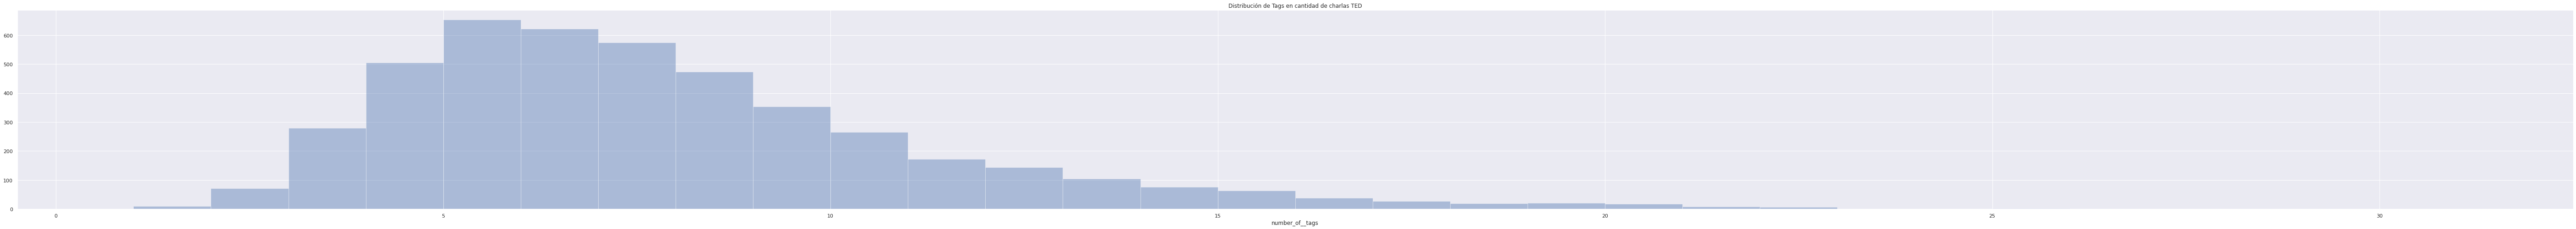

In [292]:
#datos['number_of__tags'].value_counts()
sns.distplot(datos["number_of__tags"]
             , hist=True, kde=False, bins=30).set_title('Distribución de Tags en cantidad de charlas TED')
sns.set(rc={'figure.figsize':(100,8)})

El dataset contiene 347 labels, algunos de ellos con presencia en solo una o dos de las más de 5.000 charlas TED.

In [293]:
# generación de data set para análisis de tags.
s = datos.apply(lambda x: pd.Series(x['talks__tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'temas'
temas_df = datos.drop('talks__tags', axis=1).join(s)
temas_df = temas_df.dropna()
temas_df = temas_df[['temas']]

# conteo de valores únicos en la variable theme
temas_df['temas'].value_counts()

science          1107
technology       1050
TED-Ed            744
culture           738
animation         671
                 ... 
pain                2
NASA                1
goal-setting        1
Hinduism            1
crowdsourcing       1
Name: temas, Length: 347, dtype: int64

In [294]:
#Verificamos el balance de clases
pop_temas = pd.DataFrame(temas_df['temas'].value_counts()).reset_index()
pop_temas.columns = ['temas', 'talks']

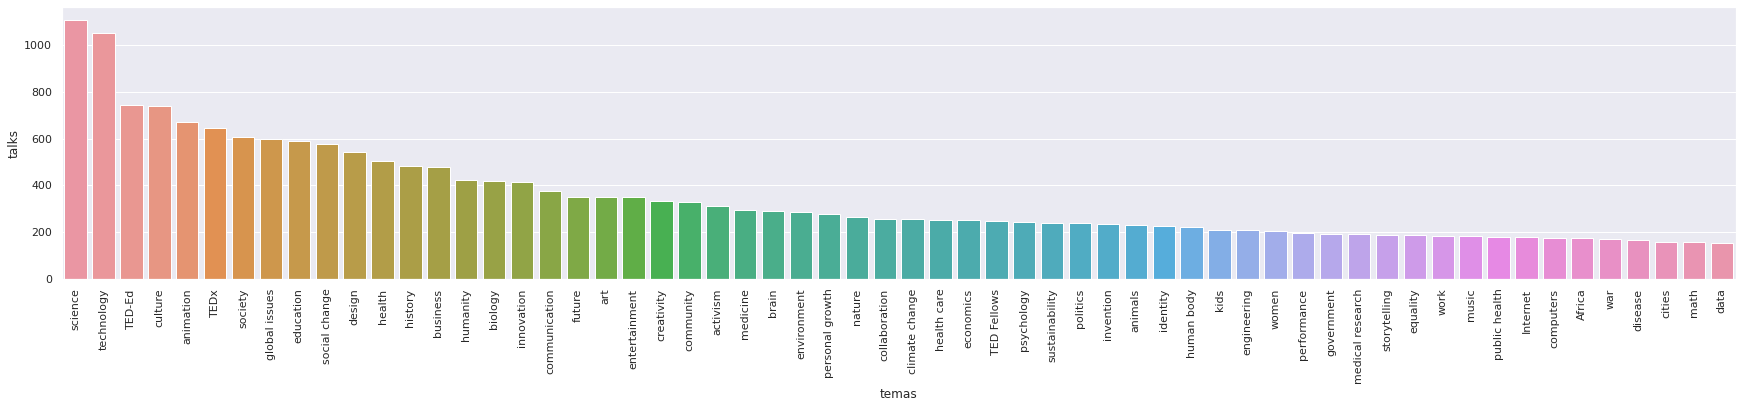

In [295]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.head(60))
plt.xticks(rotation=90)
plt.show()

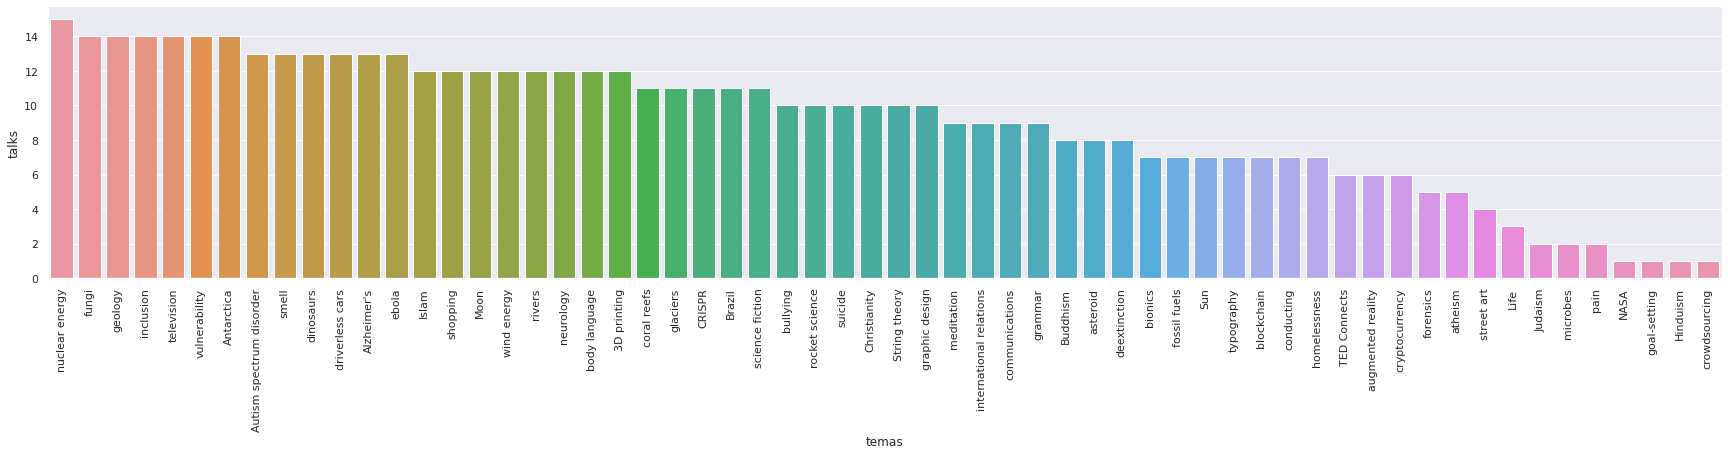

In [296]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.tail(60))
plt.xticks(rotation=90)
plt.show()

##### *Preprocesamiento de la variable talks__tags*

Para poder reducir la dimensionalidad de la variable `talks__tags`, necesitamos aplicar los siguientes pasos de preprocesamiento:

- [ ] Eliminar los espacios (3D printing -> 3d_printing): el uso de synsets no reconoce las ngrams separadas por espacios, pero sí por letras 
- [ ] Colocar todas las palabras en minúscula: en particular por ordenamiento
- [ ] Eliminar algunos tags: como el caso de los referidos a TED*** o que no tengan un Synset asociado

In [297]:
# Creando una lista con los talks__tags
temas = list(set(temas_df['temas']))

In [298]:
# Eliminando los tags TED*
ted = re.compile("TED*.")
tedlist = list(filter(ted.match, temas))
temas = [word for word in temas if word not in tedlist]

In [299]:
# Colocando todo el texto en minúscula
for i in range(len(temas)):
    temas[i] = temas[i].lower()

In [300]:
# Remplazando espacios por el caracter _
temas = [sub.replace(' ', '_') for sub in temas]

In [301]:
# Ordenando la lista
temas.sort()
pp.pprint(temas)

[   '3d_printing', 'activism', 'addiction', 'africa', 'aging', 'agriculture',
    'ai', 'aids', 'algorithm', 'aliens', "alzheimer's", 'ancient_world',
    'animals', 'animation', 'antarctica', 'anthropocene', 'anthropology',
    'archaeology', 'architecture', 'art', 'asia', 'asteroid', 'astrobiology',
    'astronomy', 'atheism', 'audacious_project', 'augmented_reality',
    'autism_spectrum_disorder', 'bacteria', 'beauty', 'bees',
    'behavioral_economics', 'best_of_the_web', 'big_bang', 'biodiversity',
    'bioethics', 'biology', 'biomimicry', 'bionics', 'biosphere', 'biotech',
    'birds', 'blindness', 'blockchain', 'body_language', 'books', 'botany',
    'brain', 'brazil', 'buddhism', 'bullying', 'business', 'cancer',
    'capitalism', 'chemistry', 'china', 'christianity', 'cities',
    'climate_change', 'code', 'cognitive_science', 'collaboration', 'comedy',
    'communication', 'communications', 'community', 'compassion', 'computers',
    'conducting', 'consciousness', 'conservat

##### Reducción de la dimensionalidad

###### Affinity Propagation Clustering Algorithm

Usando el algoritmo *Affinity Propagation Clustering Algorithm* de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html) vamos a intentar reducir la dimensionalidad de nuestras 350 tags.

Básicamente se va a utilizar los synsets de cada palabra. Es importante en este punto identificar y eliminar o remplazar las palabras que no tengan synset dado que la posterior aplicación del modelo generará error.



In [302]:
sin_synset = []
for tema in temas:
    try:
        print(tema, wn.synsets(tema)[0])
    except:
        sin_synset.append(tema)
        print(tema, 'SIN SYNSET')

3d_printing SIN SYNSET
activism Synset('activism.n.01')
addiction Synset('addiction.n.01')
africa Synset('africa.n.01')
aging Synset('ripening.n.02')
agriculture Synset('agribusiness.n.01')
ai Synset('army_intelligence.n.01')
aids Synset('aids.n.01')
algorithm Synset('algorithm.n.01')
aliens Synset('foreigner.n.01')
alzheimer's Synset('alzheimer's_disease.n.01')
ancient_world SIN SYNSET
animals Synset('animal.n.01')
animation Synset('animation.n.01')
antarctica Synset('antarctica.n.01')
anthropocene SIN SYNSET
anthropology Synset('anthropology.n.01')
archaeology Synset('archeology.n.01')
architecture Synset('architecture.n.01')
art Synset('art.n.01')
asia Synset('asia.n.01')
asteroid Synset('asteroid.n.01')
astrobiology Synset('exobiology.n.01')
astronomy Synset('astronomy.n.01')
atheism Synset('atheism.n.01')
audacious_project SIN SYNSET
augmented_reality SIN SYNSET
autism_spectrum_disorder SIN SYNSET
bacteria Synset('bacteria.n.01')
beauty Synset('beauty.n.01')
bees Synset('bee.n.01'

In [303]:
pp.pprint(sin_synset)

[   '3d_printing', 'ancient_world', 'anthropocene', 'audacious_project',
    'augmented_reality', 'autism_spectrum_disorder', 'behavioral_economics',
    'best_of_the_web', 'biomimicry', 'blockchain', 'coronavirus', 'crispr',
    'crowdsourcing', 'cryptocurrency', 'cyber_security', 'decision-making',
    'deextinction', 'driverless_cars', 'global_issues', 'goal-setting',
    'indigenous_peoples', 'industrial_design', 'international_development',
    'international_relations', 'justice_system', 'lgbtqia+', 'machine_learning',
    'marine_biology', 'medical_imaging', 'medical_research', 'mission_blue',
    'natural_disaster', 'online_privacy', 'personal_growth', 'product_design',
    'public_health', 'public_space', 'renewable_energy', 'rocket_science',
    'sexual_violence', 'social_change', 'social_media', 'storytelling',
    'street_art', 'synthetic_biology', 'ux_design', 'wind_energy',
    'women_in_business', 'work-life_balance']


In [304]:
temas_apc = [word for word in temas if word not in sin_synset]
pp.pprint(temas_apc)

[   'activism', 'addiction', 'africa', 'aging', 'agriculture', 'ai', 'aids',
    'algorithm', 'aliens', "alzheimer's", 'animals', 'animation', 'antarctica',
    'anthropology', 'archaeology', 'architecture', 'art', 'asia', 'asteroid',
    'astrobiology', 'astronomy', 'atheism', 'bacteria', 'beauty', 'bees',
    'big_bang', 'biodiversity', 'bioethics', 'biology', 'bionics', 'biosphere',
    'biotech', 'birds', 'blindness', 'body_language', 'books', 'botany',
    'brain', 'brazil', 'buddhism', 'bullying', 'business', 'cancer',
    'capitalism', 'chemistry', 'china', 'christianity', 'cities',
    'climate_change', 'code', 'cognitive_science', 'collaboration', 'comedy',
    'communication', 'communications', 'community', 'compassion', 'computers',
    'conducting', 'consciousness', 'conservation', 'consumerism', 'coral_reefs',
    'corruption', 'countdown', 'creativity', 'crime', 'culture', 'curiosity',
    'dance', 'dark_matter', 'data', 'death', 'demo', 'democracy', 'depression',
    'de

###### Wu-Palmer Similarity

Usando la distancia **Wu-Palmer Similarity** y cambiando el parámetro `affinity`.

In [305]:
def propagate_affinity(affinity_type, similarity, words_apc):
  affprop = AffinityPropagation(affinity=affinity_type, damping=0.5)
  affprop.fit(similarity)
  for cluster_id in np.unique(affprop.labels_):
    exemplar = words_apc[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words_apc[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

In [306]:
words_apc = np.asarray(temas_apc)
words_path = np.asarray(temas) 
similarity_wup = np.array([[wn.synsets(w1)[0].wup_similarity(wn.synsets(w2)[0]) for w1 in words_apc] for w2 in words_apc])
similarity_path = np.array([[wn.synsets(w1)[0].path_similarity(wn.synsets(w2)[0]) for w1 in words_apc] for w2 in words_apc])
similarity_wup[similarity_wup == None] = 0
similarity_path[similarity_path == None] = 0

In [307]:
# Aplicando el modelo APC con la distancia Wu-Palmer Similarity
propagate_affinity("precomputed", similarity_wup, words_apc)

 - *aging:* aging, climate_change, evolution, sex
 - *animals:* aliens, animals, bacteria, bees, birds, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *antarctica:* africa, antarctica, asia, europe, south_america
 - *architecture:* architecture, library, plants, prison, theater
 - *art:* art, books, dance, film, glaciers, innovation, maps, painting, toys
 - *biodiversity:* biodiversity, diversity
 - *biology:* astrobiology, biology, biotech, genetics, medicine, microbiology, neurology, neuroscience, prosthetics, surgery
 - *consciousness:* alzheimer's, consciousness, curiosity, depression, mental_health, self
 - *creativity:* atheism, consumerism, creativity, democracy, ethics, invention, meditation, motivation, pain, smell
 - *data:* botany, capitalism, data, flight, fungi, gender, law, primates, solar_system
 - *dna:* dna, spoken_word, water
 - *emotions:* compassion, emotions, empathy, fear, happiness, health, life, love, slav

In [308]:
propagate_affinity("euclidean", similarity_wup, words_apc)

 - *aids:* aids, alzheimer's, blindness, cancer, disability, disease, ebola, health, illness, ptsd
 - *bacteria:* aliens, animals, bacteria, bees, birds, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *cities:* biosphere, brazil, china, cities, egypt, india, middle_east, united_states
 - *code:* body_language, code, comedy, demo, graphic_design, humor, language, literature, music, poetry, science_fiction, software
 - *community:* ai, botany, buddhism, business, capitalism, community, culture, data, family, flight, fungi, gender, government, hinduism, islam, judaism, law, military, nasa, primates, society, solar_system
 - *electricity:* climate_change, electricity, energy, nuclear_energy, sex, solar_energy, weather
 - *europe:* africa, antarctica, asia, coral_reefs, europe, glaciers, south_america
 - *geology:* anthropology, archaeology, astrobiology, astronomy, bioethics, biology, bionics, biotech, chemistry, cognitive_science, c

In [309]:
# Aplicando el modelo APC con la distancia Path Similarity
propagate_affinity("precomputed", similarity_path, words_path)

 - *activism:* activism, future, mission_blue, moon, motivation, nature, physics, social_change
 - *agriculture:* agriculture, economics, library
 - *ancient_world:* ancient_world, illness, money
 - *animals:* addiction, animals, archaeology, drones, potential
 - *anthropocene:* anthropocene, identity, microbes, music, relationships
 - *anthropology:* anthropology, consciousness, graphic_design, indigenous_peoples, marine_biology, renewable_energy
 - *atheism:* atheism, cyber_security, happiness
 - *augmented_reality:* augmented_reality, culture
 - *bacteria:* art, bacteria, behavioral_economics, family, investing, machine_learning
 - *best_of_the_web:* alzheimer's, best_of_the_web, crime, energy
 - *big_bang:* big_bang, crispr
 - *code:* aliens, code, conducting, countdown, interview, personal_growth
 - *community:* asteroid, community, hearing, maps, planets
 - *crowdsourcing:* business, capitalism, climate_change, crowdsourcing, forensics, health_care, natural_disaster, neurology, p

###### Path similarity

##### Creando Json

Se crea un archivo JSON que contiene el resuldato de la reduccion de dimensionalidad aplicada, para ser utilizada en el modelado

In [310]:
tags_json = {            
              "activism": ["activism", "policy"],
              "aging": ["aging", "climate_change", "evolution", "sex"],
              "ai": ["ai", "family", "nasa"],
              "architecture": ["architecture", "library", "plants", "prison", "theater"],
              "art": ["art", "dance", "innovation", "maps", "museums", "painting", "toys", "transportation"],
              "bacteria": ["aliens", "bacteria", "entrepreneur", "kids", "microbes", "refugees", "trees", "virus", "women", "youth"],
              "bees": ["bees", "drones", "insects"],
              "biodiversity": ["biodiversity", "diversity"],
              "biology": ["astrobiology", "biology", "biotech", "genetics", "microbiology", "neuroscience"],
              "birds": ["animals", "birds", "dinosaurs", "fish"],
              "china": ["brazil", "china", "egypt", "india", "united_states"],
              "consciousness": ["alzheimer's", "consciousness", "curiosity", "depression", "mental_health", "self"],
              "creativity": ["consumerism", "creativity", "democracy", "invention", "meditation", "pain"],
              "disability": ["blindness", "disability", "ebola"],
              "discovery": ["collaboration", "communication", "conducting", "discovery", "hearing", "interview", "protest", "public_speaking", "shopping", "violence", "war"],
              "disease": ["aids", "cancer", "disease", "illness"],
              "emotions": ["compassion", "emotions", "empathy", "fear", "happiness", "love", "slavery"],
              "energy": ["electricity", "energy", "nuclear_energy", "solar_energy", "weather"],
              "environment": ["ecology", "environment", "friendship", "inclusion"],
              "europe": ["africa", "antarctica", "asia", "coral_reefs", "europe", "south_america"],
              "film": ["books", "film", "performance", "race"],
              "finance": ["agriculture", "finance", "investing", "marketing"],
              "food": ["dark_matter", "drugs", "food", "fossil_fuels", "plastic", "vaccines", "water"],
              "gaming": ["crime", "entertainment", "gaming", "sports", "virtual_reality"],
              "gardening": ["farming", "gardening"],
              "health_care": ["health_care", "philanthropy"],
              "hinduism": ["buddhism", "hinduism", "judaism"],
              "language": ["body_language", "code", "comedy", "demo", "graphic_design", "humor", "language", "literature", "music", "poetry", "science_fiction", "software"],
              "law": ["botany", "capitalism", "data", "flight", "fungi", "gender", "law", "primates", "solar_system"],
              "life": ["animation", "life", "potential"],
              "media": ["computers", "glaciers", "internet", "journalism", "media", "robots"],
              "medicine": ["medicine", "neurology", "prosthetics", "surgery"],
              "memory": ["goals", "illusion", "memory", "sight", "visualizations"],
              "middle_east": ["biosphere", "cities", "middle_east"],
              "motivation": ["atheism", "ethics", "motivation", "smell"],
              "natural_resources": ["natural_resources", "resources"],
              "nature": ["beauty", "corruption", "equality", "humanity", "nature", "productivity"],
              "ocean": ["brain", "ocean", "rivers"],
              "parenting": ["parenting", "transgender"],
              "personality": ["fashion", "future", "health", "history", "identity", "infrastructure", "mindfulness", "money", "personality", "sound", "space", "sustainability"],
              "philosophy": ["christianity", "feminism", "heart", "magic", "philosophy", "religion"],
              "planets": ["asteroid", "human_body", "mars", "moon", "planets", "sun", "universe"],
              "pregnancy": ["addiction", "homelessness", "pollution", "poverty", "pregnancy", "ptsd", "sleep", "vulnerability"],
              "quantum": ["human_rights", "quantum", "string_theory"],
              "relationships": ["dna", "politics", "relationships", "spoken_word", "trust"],
              "science": ["anthropology", "archaeology", "astronomy", "bioethics", "bionics", "chemistry", "cognitive_science", "communications", "economics", "geology", "grammar", "math", "nanotechnology", "paleontology", "physics", "psychology", "science", "sociology", "statistics", "urban_planning"],
              "society": ["business", "community", "culture", "government", "islam", "military", "society"],
              "success": ["big_bang", "conservation", "death", "pandemic", "success", "time"],
              "travel": ["exploration", "immigration", "suicide", "travel"],
              "work": ["algorithm", "bullying", "countdown", "design", "education", "encryption", "engineering", "exercise", "forensics", "leadership", "manufacturing", "photography", "surveillance", "typography", "work", "writing"],
            }

tags_final = json.dumps(tags_json)
jsonFile = open("tags_final.json", "w")
jsonFile.write(tags_final)
jsonFile.close()


##### Carga de JSON

In [311]:
fileObject = open("tags_final.json", "r")
jsonContent = fileObject.read()
df_tags = json.loads(jsonContent)

In [312]:
def reduce_tags(talk__tags):
  return [key for key, values in df_tags.items() for value in values if value in talk__tags]

tedx_df.talks__tags = tedx_df.apply(lambda x: reduce_tags(x.talks__tags), axis=1)

### 02.Modelado

#### 02.00 - Train / Test Split

In [313]:
X_train, X_test, y_train, y_test = train_test_split(tedx_df.transcript, tedx_df.talks__tags, test_size=.10)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')
del tedx_df
gc.collect()

26909

In [314]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=pre_procesamiento_texto)

#### 02.01 - Stacking

In [315]:
mlb = MultiLabelBinarizer()

estimators = [
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('ab', AdaBoostClassifier()),
    ('nb', GaussianNB()),
    ('gb', GradientBoostingClassifier())
]

# Con Stacking de 5 modelos + decision final con regresion logistica
#model = OneVsRestClassifier(StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))

# Con LinearSVC funciona muy bien y tarda menos que todo el stacking
model = OneVsRestClassifier(LinearSVC())

In [316]:
class DenseTransformer():
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [317]:
ml_pipeline = Pipeline(steps=[
                              ('preprocessor', tfidf_vectorizer),
                              ('to_dense', DenseTransformer()), 
                              ('classifier', model)
])

In [318]:
ml_pipeline.fit(X_train, mlb.fit_transform(y_train))

Pipeline(memory=None,
         steps=[('preprocessor',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pa...
                                 use_idf=True, vocabulary=None)),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x7f7e354e9910>),
                ('classifier',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                        

In [319]:
# Predice X_test
y_pred = [list(predicted_row) for predicted_row in mlb.inverse_transform(ml_pipeline.predict(X_test))]

In [ ]:
pp.pprint(y_pred)

In [322]:
pp.pprint(y_test)

3759    [creativity, language, media, relationships, s...
148     [ai, biology, biology, consciousness, memory, ...
4801    [ai, environment, personality, personality, work]
2070    [consciousness, memory, philosophy, science, s...
1981    [finance, nature, relationships, science, soci...
                              ...                        
2733                                   [science, science]
349                                [media, science, work]
2128                   [life, personality, society, work]
4054    [art, creativity, creativity, discovery, life,...
884         [discovery, emotions, science, society, work]
Name: talks__tags, Length: 452, dtype: object


### 03.Evaluación del modelo

#### Puntaje de hamming

Al utilizar multi-class multi-label, obtener el accuracy del modelo es una de las opciones que se tienen, pero el apunta a que la totalidad de los tags predichos se encuentre en los tags del set de test.

Utilizando el puntaje de hamming buscamos la intersección entre los tags verdaderos (los del set de datos de test) y los tags que se predijeron.

In [323]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [324]:
print(f'{hamming_score(np.array(y_test), np.array(y_pred)) * 100}%')

50.387832697887426%


#### Accuracy

Como se menciono previamente, con el accuracy vamos a buscar obtener la igualdad total entre lo predicho y lo verdadero. Marcando como predicción erronea si de 10 tags que tiene una charla unicamente uno se predijo de manera incorrecta.

In [325]:
sparse_y_test = mlb.transform(y_test)
sparse_y_pred = mlb.transform(y_pred)

print(f'{accuracy_score(sparse_y_test, sparse_y_pred) * 100}%')

3.761061946902655%


#### Recall

Nos muestra la habilidad del modelo de taggear charlas de manera correcta.

<p align="center">
<img src="https://pinatadata.com/wp-content/uploads/2019/10/recall.png">
</p>

Primero procedemos a calcular el recall de manera global sin entrar en detalle en cada una de las etiquetas

In [326]:
print(f'{recall_score(sparse_y_test, sparse_y_pred, average="micro") * 100}%')

40.33391915641476%


Calculamos el recall de cada una de las etiquetas teniendo en cuenta su peso dentro del dataset.

In [327]:
print(f'{recall_score(sparse_y_test, sparse_y_pred, average="weighted") * 100}%')

40.33391915641476%


#### Precision

Nos indica la habilidad del modelo para no taggear charlas de manera incorrecta.

<p align="center">
<img src="https://pinatadata.com/wp-content/uploads/2019/10/precision.png" />
</p>

Se utilizo los mismos enfoques que para calcular el recall

In [328]:
print(f'{precision_score(sparse_y_test, sparse_y_pred, average="micro") * 100}%')

68.81559220389805%


In [329]:
print(f'{precision_score(sparse_y_test, sparse_y_pred, average="weighted") * 100}%')

67.76613007782878%


#### CURVA ROC Multilabel

In [355]:
#Tags Fit
y_score = ml_pipeline.fit(X_train, mlb.fit_transform(y_train)).decision_function(X_test)

y_test_fit = mlb.fit_transform(y_test)

In [452]:
#Complementos
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

#Definiciones
n_classes = len(y_test_fit[0])
fpr = dict()
tpr = dict()
roc_auc = dict()

In [453]:
#Curva ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_fit[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_fit.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

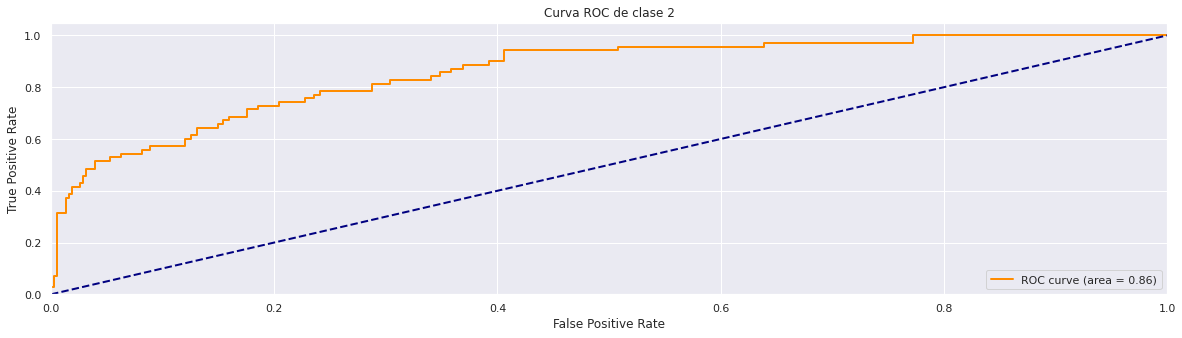

In [454]:
#Ploteo Clase n

ClasePlot = 5

plt.figure(figsize=(20,5))
lw = 2
plt.plot(fpr[ClasePlot], tpr[ClasePlot], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ClasePlot])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title((f'Curva ROC de clase {lw}'))
plt.legend(loc="lower right")
plt.show()

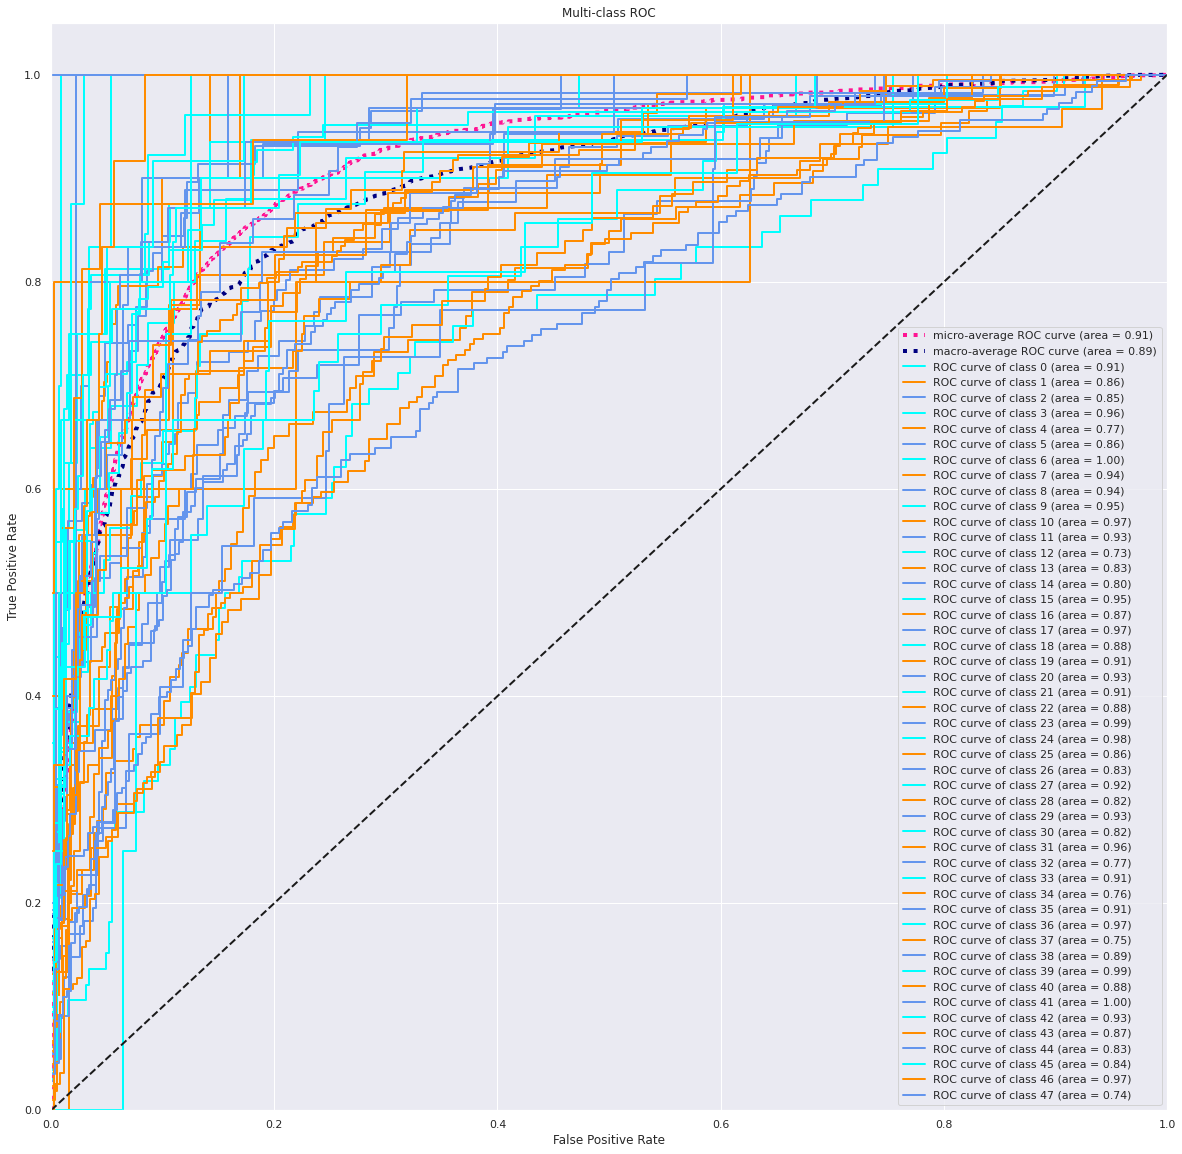

In [455]:
#Ploteo Global

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()